In [1]:
"""
    an example of plotting the COLD curve 
"""

import numpy as np
import os
from os.path import join
import glob
import pandas as pd
from datetime import datetime
from pycold import cold_detect   # pycold is workable on Mac and Linux system. Windows system is not workable at present
from osgeo import gdal, gdal_array, gdalconst
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

pwd = os.getcwd()
rootpath = os.path.abspath(os.path.join(pwd, '..'))

from cold_running.cold_running import cold_data_prepare

list_band_name = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']


def datenum_to_datetime(datenum):
    """
        convert datenum to datetime
    """
    python_datetime = datetime.fromordinal(int(datenum))
    return python_datetime


def standard_CCD (time_series, parameter):
    """
        the 

    Args:
        time_series: time series of array datenum
        parameter: harmonic function coefficient

    Returns:
        _type_: _description_
    """
    pi = np.pi
    omega = 2 * pi / 365.25
    surface_reflectance = np.dot(np.array([np.ones(np.shape(time_series)), time_series / 10000,
                                           np.cos(omega * time_series), np.sin(omega * time_series),
                                           np.cos(2 * omega * time_series), np.sin(2 * omega * time_series),
                                           np.cos(3 * omega * time_series), np.sin(3 * omega * time_series)]).T, parameter)
    return surface_reflectance


def get_breakcategory(ccd_plot, i_curve):
    """
    get break category:
    :param ccd_plot: rec_cg
    :param i_curve: the number of the curve to be analysised
    :return: 1 - disturbance break; 2 - natural recovery; 3 - aforestation
    see section 3.3.7 in Zhu, Z., Zhang, J., Yang, Z., Aljaddani, A. H., Cohen, W. B., Qiu, S., & Zhou, C. (2020).
    Continuous monitoring of land disturbance based on Landsat time series. Remote Sensing of Environment, 238, 111116.
    """
    t_c = -200
    
    if ccd_plot[i_curve]['magnitude'][3] > t_c and ccd_plot[i_curve]['magnitude'][2] < -t_c and \
            ccd_plot[i_curve]['magnitude'][4] < -t_c:
        if ccd_plot[i_curve + 1]['coefs'][3, 1] > np.abs(ccd_plot[i_curve]['coefs'][3, 1]) and \
                ccd_plot[i_curve + 1]['coefs'][2, 1] < -np.abs(ccd_plot[i_curve]['coefs'][2, 1]) and \
                ccd_plot[i_curve + 1]['coefs'][4, 1] < -np.abs(ccd_plot[i_curve]['coefs'][4, 1]):
            return 3
        else:
            return 2
    else:
        return 1


def cold_plot_data_preparation(df, singlepathid, row_id_in_block, col_id_in_block):
    """
    prepare the data for the COLD plotting
    Args:
        df: the dataframe contains all block files
        row_id_inblock
        col_id_inblock
        singlepathid: the WRS path id
    Returns:
        img_stacking: the stacked block file for plotting
        df_return: the dataframe containing the data point information
    """

    img_stacking = df['stacking_data'][(df['pathid'] == singlepathid).values].values[0]
    array_obsdatenum = df['obsnum'][(df['pathid'] == singlepathid).values].values[0]

    blues = img_stacking[:, 0, row_id_in_block, col_id_in_block].astype(np.int64)
    greens = img_stacking[:, 1, row_id_in_block, col_id_in_block].astype(np.int64)
    reds = img_stacking[:, 2, row_id_in_block, col_id_in_block].astype(np.int64)
    nirs = img_stacking[:, 3, row_id_in_block, col_id_in_block].astype(np.int64)
    swir1s = img_stacking[:, 4, row_id_in_block, col_id_in_block].astype(np.int64)
    swir2s = img_stacking[:, 5, row_id_in_block, col_id_in_block].astype(np.int64)
    thermals = img_stacking[:, 6, row_id_in_block, col_id_in_block].astype(np.int64)
    qas = img_stacking[:, 7, row_id_in_block, col_id_in_block].astype(np.int64)

    array_data = np.array([array_obsdatenum, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas])
    df_return = pd.DataFrame(array_data.T, columns=['dates'] + list_band_name + ['qa'])
    
    return img_stacking, array_obsdatenum, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, df_return


def COLD_plot(df_plot, cold_result_singlepixel, title=None, list_plot_band_name=None, set_limit_flag=0, limit_pct=99):
    """
        plot the COLD curve, including the clear observations and COLD-fitted curves 

    Args:
        df_plot: the dataframe containing the pixels for plotting 
        cold_result_singlepixel: the COLD-fitted parameters for the plotting pixel 
        title (optional): plot title. Defaults to None.
        list_plot_band_name (optional): the band name wants to be plotted. full list is ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']. Defaults to None, i.e., all bands are plotted
        set_limit_flag (int, optional): the flag to indicate whether to limit the y-axis. Defaults to 0 (no limitation).
        limit_pct (int, optional): the range to limit the observation. Defaults to 99.
    """

    sns.set(style="darkgrid")
    sns.set_context("notebook")

    if list_plot_band_name is None:
        list_plot_band_name = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']
    array_obsdatenum = df_plot['dates'].values

    qas = df_plot['qa'].values
    mask = (qas == 0) | (qas == 1)

    # get the observation datetime
    array_obsdatetime = []
    for i_obsdates in range(0, len(array_obsdatenum)):
        array_obsdatetime.append(datenum_to_datetime(array_obsdatenum[i_obsdates]))
    array_obsdatetime = np.array(array_obsdatetime)

    labelsize = 15
    axis_label_size = 12
    legend_size = 9
    lw_model_fit = 2
    lw_break = 0.5

    fig, axes = plt.subplots(ncols=1, nrows=len(list_plot_band_name), squeeze=False, figsize=(10, 2.5 * len(list_plot_band_name)))

    axes[0, 0].set_title(title, fontsize=labelsize)  # set the plot title

    # plot the observation points
    for band_id in range(0, len(list_plot_band_name)):
        if list_plot_band_name[band_id] != 'Thermal':
            axes[band_id, 0].set_ylabel(list_plot_band_name[band_id] + '*10000', size=axis_label_size)
            sr_plot_tmp = df_plot.loc[:, list_plot_band_name[band_id]][mask]
            axes[band_id, 0].plot(array_obsdatetime[mask], sr_plot_tmp, '.', color='cornflowerblue', label='observations')

            ylim_min = np.nanpercentile(sr_plot_tmp, 100 - limit_pct)
            ylim_max = np.nanpercentile(sr_plot_tmp, limit_pct)

        else:
            thermal_tmp = df_plot.loc[:, list_band_name[band_id]][mask] * 10 - 27320

            axes[band_id, 0].set_ylabel(list_plot_band_name[band_id] + '*10 (Celsius Degree)', size=axis_label_size)
            axes[band_id, 0].plot(array_obsdatetime[mask], thermal_tmp, '.', color='cornflowerblue', label='observations')

            ylim_min = np.nanpercentile(thermal_tmp, 100 - limit_pct)
            ylim_max = np.nanpercentile(thermal_tmp, limit_pct)

        # set the y-axis limitation
        if set_limit_flag == 0:
            pass
        else:
            axes[band_id, 0].set_ylim([ylim_min, ylim_max])

    # plot the COLD-fitted curves
    for i_reccg in range(0, len(cold_result_singlepixel)):

        cold_result_single_reccg = cold_result_singlepixel[i_reccg]

        t_start = cold_result_single_reccg['t_start']
        t_end = cold_result_single_reccg['t_end']
        time_series = np.arange(t_start, t_end)
        plot_time_series = pd.date_range(datenum_to_datetime(time_series[0]), datenum_to_datetime(time_series[-1]), freq='D')

        ccd_coefs = cold_result_single_reccg['coefs']

        for band_id in range(0, len(list_plot_band_name)):
            coefs_each_band = ccd_coefs[np.array(list_band_name) == list_plot_band_name[band_id]][0, :]
            surface_reflectance = standard_CCD(time_series, coefs_each_band)

            axes[band_id, 0].plot(plot_time_series, surface_reflectance, color='darkorange', label='Model fit', linewidth=lw_model_fit)
    
    # plot the break line
    for band_id in range(0, len(list_plot_band_name)):
        for i_reccg in range(0, len(cold_result_singlepixel) - 1):
            if get_breakcategory(cold_result_singlepixel, i_reccg) == 2:  # recovery break
                axes[band_id, 0].axvline(pd.Timestamp.fromordinal(cold_result_singlepixel[i_reccg]['t_break']), color='r', linewidth=lw_break)
            else:
                axes[band_id, 0].axvline(pd.Timestamp.fromordinal(cold_result_singlepixel[i_reccg]['t_break']), color='k', linewidth=lw_break)

    # set the x-axis range
    for band_id in range(0, len(list_plot_band_name)):
        x_axis_range = pd.date_range(datetime(year=1982, month=1, day=1), datetime(year=2024, month=1, day=1), freq='2Y')

        axes[band_id, 0].set_xticks(x_axis_range)
        axes[band_id, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axes[band_id, 0].set_xlim(datetime(year=1982, month=1, day=1), datetime(year=2024, month=1, day=1), )

    # set the legend
    legend_elements = [Line2D([0], [0], color='black', lw=lw_break, label='Disturbance break'),
                       Line2D([0], [0], color='red', lw=lw_break, label='Recovery break'),
                       Line2D([0], [0], color='orange', lw=lw_model_fit, label='Model fit'),
                       Line2D([], [], color='b', marker='.', linestyle='None', markersize=8, label='observations')]
    axes[band_id, 0].legend(handles=legend_elements, ncol=len(legend_elements), loc='best', prop={'size': legend_size})

    plt.tight_layout()
    plt.show()

    return None

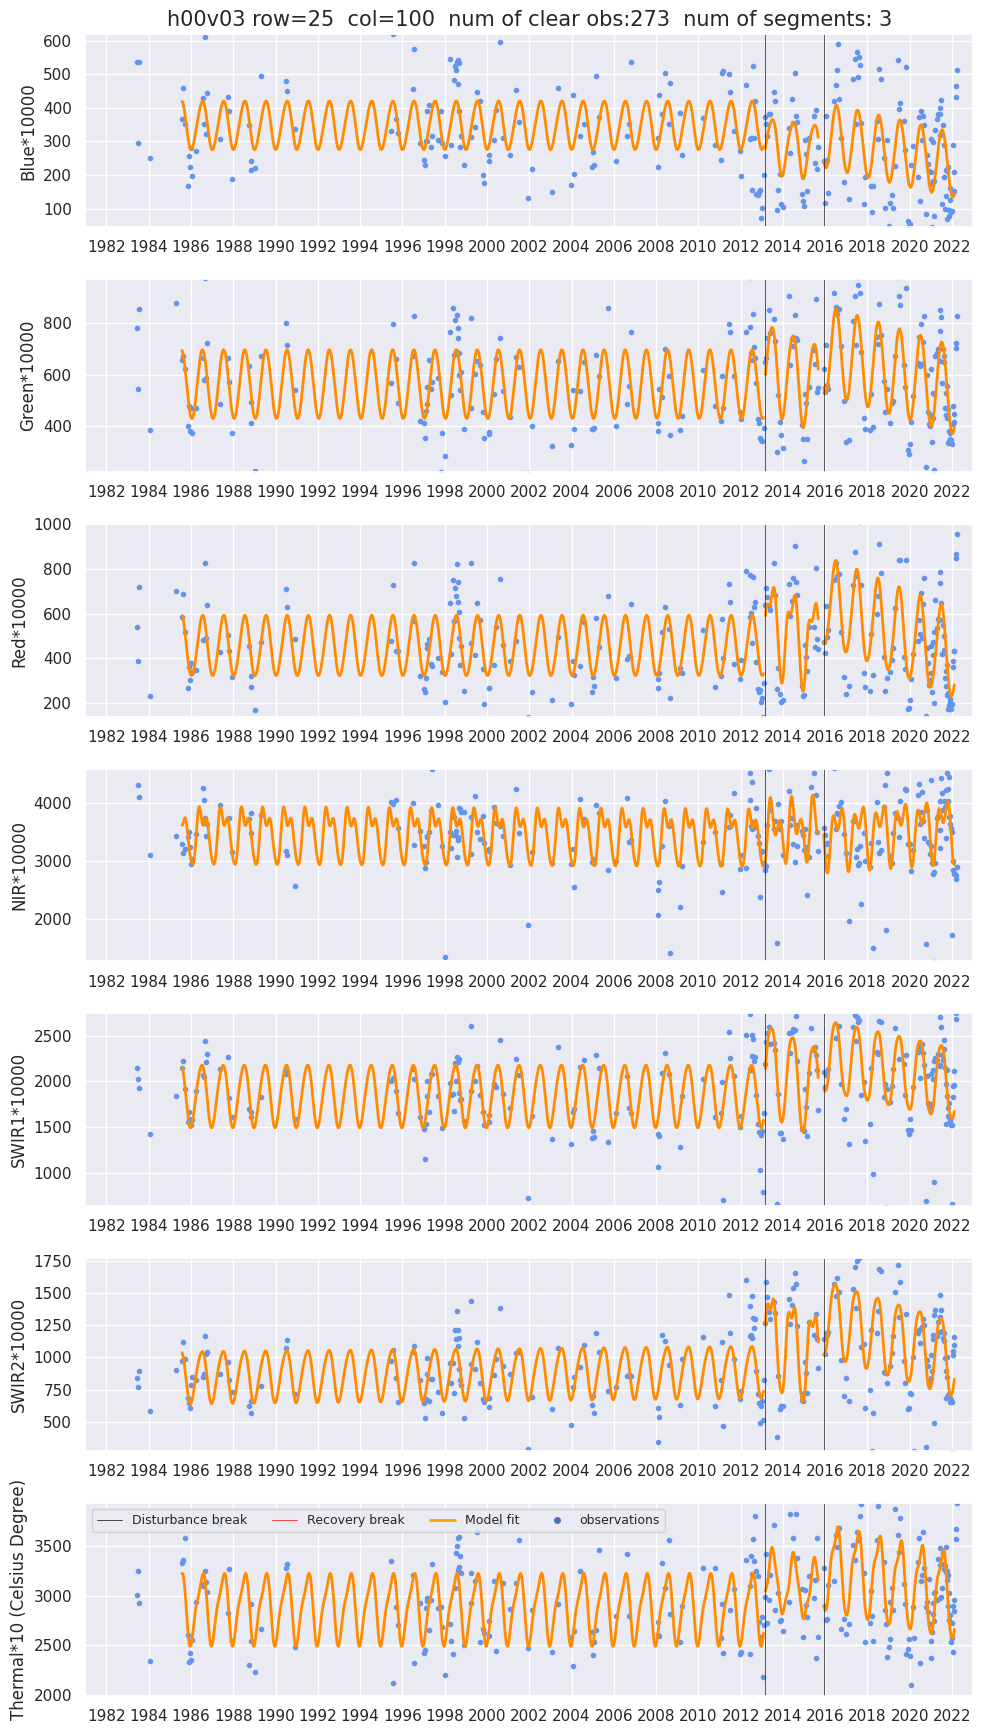

In [2]:
if __name__ == '__main__':
   
    tilename = 'h00v03'
    blockname = 'row1000col1750'
    row_id_in_block, col_id_in_block = 25, 100
    list_plot_band_name = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']  # the band name to plot, full list is ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']
    # list_plot_band_name = ['NIR']

    cold_output_foldername = 'COLD_output'
    
    img_wrsid = gdal_array.LoadFile(join(rootpath, 'data', 'single_path', '{}.tif'.format(tilename)))
    singlepathid = '%03d' % (img_wrsid[row_id_in_block, col_id_in_block])
    
    block_path = join(rootpath, 'data', 'cold_running', tilename, blockname)
    list_filename = glob.glob(join(block_path, '*.npy'))
    
    # get the dataset for the whole block
    df = cold_data_prepare(list_filename)  

    # extract the data point the selected pixel 
    img_stacking, array_obsdatenum, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, df_return = cold_plot_data_preparation(df, singlepathid, row_id_in_block, col_id_in_block)
    
    mask = (qas == 0) | (qas == 1)
    num_clear_obs = np.count_nonzero(mask)

    try:
        Block_Size = 250
        pos = row_id_in_block * Block_Size + col_id_in_block + 1
        cold_result_singlepixel = cold_detect(array_obsdatenum, blues, greens, reds, nirs, swir1s, swir2s, thermals,
                                                qas, pos=pos, conse=4, t_cg=11.07, b_c2=True)

        title = '{} row={}  col={}  num of clear obs:{}  num of segments: {}'. format(tilename, row_id_in_block, col_id_in_block, num_clear_obs, len(cold_result_singlepixel))

        COLD_plot(df_return, cold_result_singlepixel, title=title, list_plot_band_name=list_plot_band_name, set_limit_flag=1, limit_pct=97)

    except Exception as e:
        print('COLD failed', 'reason: ', e)
        

In [3]:
df_return

,dates,Blue,Green,Red,NIR,SWIR1,SWIR2,Thermal,qa
0,724341,732,964,938,3051,-7,-13,1500,3
1,724432,535,782,542,4931,2146,844,3033,0
2,724448,295,544,390,4314,2026,772,3057,0
3,724464,537,853,721,4101,1925,892,3025,0
4,724624,333,361,290,1709,689,301,2931,2
...,...,...,...,...,...,...,...,...,...
507,738576,3886,3903,4019,4624,4274,3669,2906,4
508,738584,464,721,865,2762,2746,1842,3100,0
509,738592,432,704,848,2695,2680,1798,3089,0
510,738600,10175,9529,9709,9497,6181,4621,2792,4
